**Table of Contents**

1. Introduction
2. TPU, GPU or CPU detection
3. Data Handling
4. Preprocess the data
5. Label Mapping
6. Building and Training
7. Generate predictions
8. Grad-CAM activation visualization
9. Improvement of Model

**1. Introduction**
     
*   This notebook is about using a pretrained ResNet 18 on Flowers dataset and visualize the layer activation for every mislabeled image with GRADCAM of the weakest class
*   GRAD-CAM or Gradient-weighted Class Activation Mapping is a gradient based localization visual explanation algorithm using heat map to indicate the image areas used as the basis for judgment in image classification by convolutional neural networks.
GRAD-CAM allows one to visualize areas of relevance for each prediction class.

In [1]:
import matplotlib.pyplot as plt
import json
import os
import torch
import torch.nn.functional as F
import shutil, os, glob
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import copy
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import tensorflow as tf
import nnabla as nn
from pytorch_grad_cam import GradCAM
from torch import nn, optim
from importlib import reload
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch import Tensor
from tensorflow import keras
from torchvision.datasets.folder import ImageFolder
from PIL import Image
from nnabla.utils.image_utils import imread
from nnabla.models.imagenet import VGG16
from gradcam import gradcam
# Display
from IPython.display import Image, display

/home/ecnw/anaconda3/envs/py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-03-11 08:11:43.309648: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ecnw/anaconda3/envs/py3.8/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:/usr/local/cuda/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda/extras/CUPTI/lib64:
2022-03-11 08:11:43.309668: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-03-11 08:11:52.347940: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not 

**2. CPU or GPU detection**

In [103]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [104]:
device

device(type='cpu')

**3. Data Handling**

In [105]:
# From the test.txt, train.txt and valid.txt create within the train, test and valid folders
# Different classes with corresponding images(i.e /train/1/image0001.jpg)


test_dir = '../Flowers/oxford-102-flowers/test.txt'
train_dir = '../Flowers/oxford-102-flowers/train.txt'
valid_dir = '../Flowers/oxford-102-flowers/valid.txt'

train_parent_dir = "../Flowers/oxford-102-flowers/train"
test_parent_dir = "../Flowers/oxford-102-flowers/test"
valid_parent_dir = "../Flowers/oxford-102-flowers/valid"
jpg_directory = '../Flowers/oxford-102-flowers/jpg'

def get_input_path(read_file_path:str)-> str:
    return read_file_path

def enter_filename_csv(filename_csv:str) -> str:
    return filename_csv+'.csv'

def get_csv_file()-> str:
    return get_input_path+enter_filename_csv

def read_file():
    pd.read_csv(get_input_path)

def read_file_to_csv():
    read_file.to_csv(get_csv_file,index=None)

file = pd.read_csv(get_csv_file)

# adding header
headerList = None
# converting data frame to csv
file.to_csv(enter_filename_csv, header=headerList, index=False)
file2 = pd.read_csv(enter_filename_csv)

list_row = []
with open(enter_filename_csv, 'r') as file:
    reader = csv.reader(file)
    data = list(reader)
    list_row.append(data)

def save_images_in_different_folders(path_name_dir):
    for i in range(0, len(list_row[0])):
        line = list_row[0][i][0]
        desired_images_train = line.split('/')[1].split('.')[0] + '.jpg'
        s = list_row[0][i][0]
        s.split(' ')[1:][0]

        # Directory 
        directory = s.split(' ')[1:][0]
        # Path
        path = os.path.join(path_name_dir, directory)

        #Check if path exist else create it
        if(os.path.exists(path)):
            pass
            #print("Directory Exists")
        else:
            os.mkdir(path)

        for root, dirs, files in os.walk(jpg_directory):
            new_name_file = os.path.join(root, desired_images_train)
            shutil.copy(new_name_file, path)  


**4. Preprocess the data**

In [106]:
data_flowers_dir = '../Flowers/oxford-102-flowers'

# We need to transform images here since we want them in a useable form for deep learning
# Convert image to tensor, Normalize data, Resizing Image, Applying random horizontalflip
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

images_dataset_flowers_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_flowers_dir, x),images_dataset_flowers_transforms[x]) for x in ['train', 'test', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'test', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'valid']}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=16, shuffle=True)

In [107]:
# Label Mapping
class_names = image_datasets['train'].classes
inputs, classes = next(iter(dataloaders['test']))
flowers_labels_path = '../Flowers/flowers_labels.json'
with open(flowers_labels_path, 'r') as flowers_labels:
    flowers_labels = json.load(flowers_labels)
    #print(flowers_labels)

{'1': 'alpine sea holly', '2': 'anthurium', '3': 'artichoke', '4': 'azalea', '5': 'ball moss', '6': 'balloon flower', '7': 'barbeton daisy', '8': 'bearded iris', '9': 'bee balm', '10': 'bird of paradise', '11': 'bishop of llandaff', '12': 'black-eyed susan', '13': 'blackberry lily', '14': 'blanket flower', '15': 'bolero deep blue', '16': 'bougainvillea', '17': 'bromelia', '18': 'king protea', '19': 'lenten rose', '20': 'lotus', '21': 'love in the mist', '22': 'magnolia', '23': 'mallow', '24': 'marigold', '25': 'mexican aster', '26': 'mexican petunia', '27': 'monkshood', '28': 'moon orchid', '29': 'morning glory', '30': 'orange dahlia', '31': 'osteospermum', '32': 'oxeye daisy', '33': 'passion flower', '34': 'pelargonium', '35': 'buttercup', '36': 'californian poppy', '37': 'camellia', '38': 'canna lily', '39': 'canterbury bells', '40': 'cape flower', '41': 'carnation', '42': 'cautleya spicata', '43': 'clematis', '44': 'colts foot', '45': 'columbine', '46': 'common dandelion', '47': 'co

In [108]:
# Method to display flowers with classes/labels
def imshow(inp, title=None):

    """Imshow for Tensor"""
    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    # Image should be clipped between 0 and 1 if not the image would be like noise
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        plt.show()

tensor([72, 33, 89, 12])


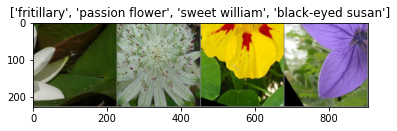

In [109]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=5)
#Displaying images
#imshow(out, title=[class_names[x] for x in classes])
imshow(out,title=[flowers_labels[str(x.item())] for x in classes])

**5. Building and Training**

We here build the classifier and unfortunately my validation accuracy is not good at all, was supposed to be at least around 80%. I tries to adjust the hyperparameters like learning rate, epochs, units in classifier in order to get the best model. Later save the model in file for later prediction

In [112]:
# Model RESNET18
resnet18 = models.resnet18(pretrained=True)

In [114]:
# Freeze parameters so we don't backprop through them
for param in resnet18.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(512, 1000)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(p=0.5)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

resnet18.class_idx_mapping = image_datasets['train'].class_to_idx

In [115]:
# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=.0015)

In [117]:
def validation(model, testloader, criterion, device):
    test_loss = 0
    accuracy = 0
    model.to(device)
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        # images.resize_(images.shape[0], 3, 224, 224)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [118]:
def train(model, trainloader, validloader, epochs, print_every, criterion, optimizer, device='cpu'):
    steps = 0
    
    # Change to train mode if not already
    model.train()
    # change to cuda
    model.to(device)
    
    best_accuracy = 0
    for e in range(epochs):
        running_loss = 0

        for (images, labels) in trainloader:
            steps += 1

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward and backward passes
            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                
                # Make sure network is in eval mode for inference
                model.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    validation_loss, accuracy = validation(model, validloader, criterion, device)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(validation_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format((accuracy/len(validloader))*100))

                model.train()
                
                running_loss = 0

In [119]:
train(model=resnet18, 
        trainloader=dataloaders['train'], 
        validloader=dataloaders['valid'],
        epochs=1, 
        print_every=20, 
        criterion=criterion,
        optimizer=optimizer,
        device="cpu")

Epoch: 1/1..  Training Loss: 8.398..  Validation Loss: 126.914..  Validation Accuracy: 0.784
Epoch: 1/1..  Training Loss: 6.744..  Validation Loss: 13.392..  Validation Accuracy: 1.863
Epoch: 1/1..  Training Loss: 6.814..  Validation Loss: 12.112..  Validation Accuracy: 0.980
Epoch: 1/1..  Training Loss: 6.181..  Validation Loss: 7.287..  Validation Accuracy: 0.784
Epoch: 1/1..  Training Loss: 6.161..  Validation Loss: 24.868..  Validation Accuracy: 1.078
Epoch: 1/1..  Training Loss: 5.383..  Validation Loss: 7.449..  Validation Accuracy: 0.588
Epoch: 1/1..  Training Loss: 5.467..  Validation Loss: 5.316..  Validation Accuracy: 1.275
Epoch: 1/1..  Training Loss: 5.154..  Validation Loss: 4.975..  Validation Accuracy: 1.078
Epoch: 1/1..  Training Loss: 5.151..  Validation Loss: 5.157..  Validation Accuracy: 0.980
Epoch: 1/1..  Training Loss: 5.164..  Validation Loss: 5.047..  Validation Accuracy: 1.176
Epoch: 1/1..  Training Loss: 5.252..  Validation Loss: 5.016..  Validation Accuracy: 

**6. Testing Network**

Testing the data of the network on test data,after doing that on training and validation data images


In [120]:
def check_accuracy_on_test(testloader, model):    
    correct = 0
    total = 0
    model.to(device)
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [121]:
test_accuracy = check_accuracy_on_test(dataloaders['test'], resnet18)
print('Accuracy of the network on the 10000 test images: %d %%' % test_accuracy)

Accuracy of the network on the 10000 test images: 2 %


In [122]:
# The indexes are needed for. All informations needed must be added here for training
# Optimizer and epochs should be saved
resnet18.class_idx_mapping = image_datasets['train'].class_to_idx

In [123]:
def save_model_resnet18(state, filename='model_resnet18.pth'):
    torch.save(state, filename)

In [124]:
save_model_resnet18({
            'epoch': 3,
            'state_dict': resnet18.state_dict(),
            'optimizer' : optimizer.state_dict(),
            'class_idx_mapping': resnet18.class_idx_mapping,
            'arch': "resnet18"
            })

In [125]:
# Load save model and rebuild the model in order not to retrain the network again
def load_model(model_resnet18):
    location = torch.load(model_resnet18)
    
    model = models.resnet18(pretrained=True)
    
    for param in model.parameters():
        param.requires_grad = False

    model.load_state_dict(location["state_dict"])
    
    return model

Original image with size: (500, 592)


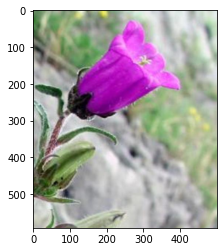

In [126]:
# Cropping anexample image
img = Image.open("../Flowers/oxford-102-flowers/train/2/image_06614.jpg")
print("Original image with size: {}".format(img.size))
plt.imshow(img)

In [127]:
# Processing an example image using PIL
def process_image(img_path):
    img = Image.open(img_path)
    a, b = img.size
    if a<b:
        size = 256, 999999999
    else:
        size = 999999999, 256

    img.thumbnail(size=size)
    
    a, b = img.size
    left = (a - 224) / 2
    right = (a + 224) / 2
    top = (b - 224) / 2
    bottom = (b + 224) / 2
    
    img = img.crop((left, top, right, bottom))
    
    # Convert to numpy array
    np_img = np.array(img)/255
    
    # Normalize
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    np_img = (np_img - mean) / std
    
    np_img = np_img.transpose(2, 0, 1)
    
    return np_img

In [128]:
img = process_image("../Flowers/oxford-102-flowers/train/2/image_06614.jpg")
print("After resizing, cropping and normalizing, size: {}".format(img.shape))

After resizing, cropping and normalizing, size: (3, 224, 224)


**7. Generate predictions**

In [129]:
# Class Prediction
class_idx_mapping = image_datasets['train'].class_to_idx
idx_class_mapping = {v: k for k, v in class_idx_mapping.items()}

In [131]:
# Function for making predictions with the model.

def predict(image_path, model_resnet18, topk=5, device="cpu", idx_class_mapping=idx_class_mapping):
    
    # Build the model from the location
    model = load_model(model_resnet18)
    
    model.to(device)
    
    model.eval()
     
    img = process_image(image_path)
    img = np.expand_dims(img, axis=0)
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor).to(device)
    
    with torch.no_grad():
        log_probabilities = model.forward(img_tensor)
    
    probabilities = torch.exp(log_probabilities)
    probs, indices = probabilities.topk(topk)
    
    probs = probs.numpy().squeeze()
    indices = indices.numpy().squeeze()
    classes = [idx_class_mapping[index] for index in indices]
    
    return probs, classes

In [132]:
def imshow_(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [133]:
# Display an image along with the top 5 classes and make sure it is correct
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[-2]
    title_ = flowers_labels[flower_num]
    # Plot flower
    img = process_image(image_path)
    #imshow(img, title = title_)
    imshow_(img, ax, title = title_)
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

AttributeError: 'ResNet' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.

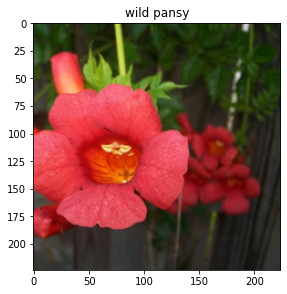

In [134]:
resnet18.eval()
image_path = '../Flowers/oxford-102-flowers/test/100/image_07943.jpg'
plot_solution(image_path, resnet18)

anthurium


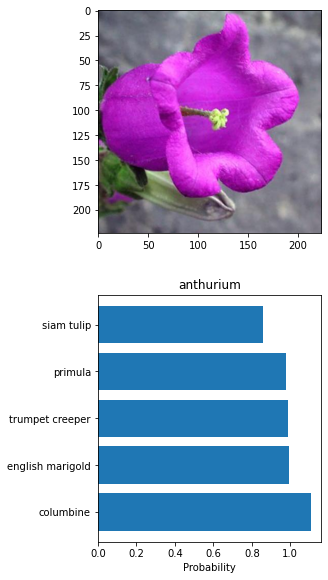

In [135]:
img_path = "../Flowers/oxford-102-flowers/test/2/image_06621.jpg"
probs, classes = predict(img_path, "checkpoint.pth", idx_class_mapping=idx_class_mapping)

class_names = [flowers_labels[c] for c in classes]

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(4,10))
class_number = img_path.split("/")[-2]
title = flowers_labels[str(class_number)]
imshow_(process_image(img_path), ax1, title)
print(title)


scalars = [*range(len(probs))]
ax2.barh(scalars, probs)
plt.xlabel("Probability")
plt.yticks(scalars, class_names)
plt.show()

**8. Grad-CAM activation visualization**

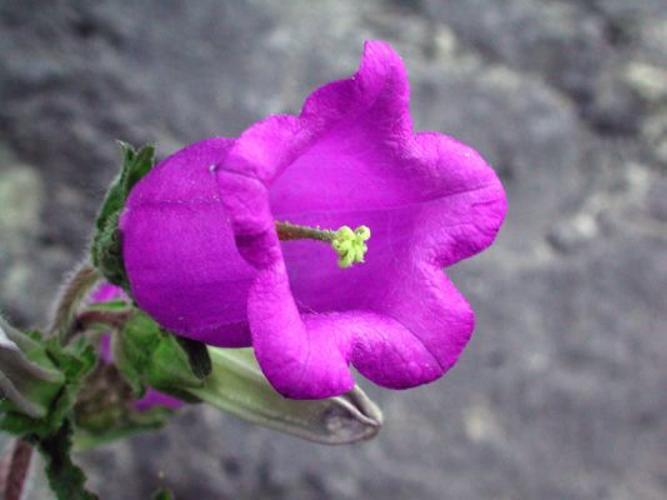

In [137]:
# Need to display the image of the weakest classes using Grad-CAM
model_grad_cam = keras.applications.xception.Xception
image_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# For the last conv layser fo model.summary()
last_conv_layer = "block8_sepconv3_act"

drive_image_path = '../Flowers/oxford-102-flowers/test/2/image_06621.jpg'
image_path = keras.utils.get_file(drive_image_path,"https://www.image-net.org")
# Display the image
Image.open(image_path)
#display(Image(image_path))

In [138]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


2022-03-11 03:44:00.358621: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-03-11 03:44:00.358735: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ecnw
2022-03-11 03:44:00.358762: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ecnw
2022-03-11 03:44:00.359059: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-03-11 03:44:00.378698: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-03-11 03:44:00.378749: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-03-11 03:44:00.481578: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operati

49152/35363 [=========================================] - 0s 1us/step
Predicted: [('n12620546', 'hip', 7.160334)]


2022-03-11 03:45:06.362593: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 49787136 exceeds 10% of free system memory.


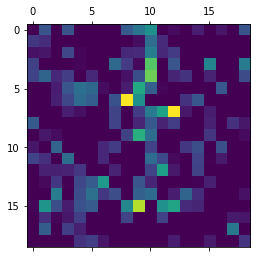

In [139]:
# Prepare image
img_array = preprocess_input(get_img_array(image_path, size=image_size))

# Make model
model = model_grad_cam(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

# Display heatmap
plt.matshow(heatmap)
plt.show()


**9. Improvement of the Model**

In order to improve the model one has to do:

     1) data augmentation       
         - Rotate image
         - Increase size of the image
         - Random Brightness
         - Random Contrast
         - Random Saturation
         - Random Crop or Pad
         - Random Rotate
         - Sharpness
      2) collect more data
    